## ALR Client Side

This notebook is a copy similar to ALR_Client_Side found in:
https://github.com/rfernand387/ALR_Earth_Engine/blob/master/ALR_Client_Side.ipynb

The input image is assumed to be in the format generated by SL2P10_control.ipynb:
https://github.com/kateharvey/Sentinel2_ALR/blob/main/shared/SL2P10_control.ipynb

In [1]:
import ee
import scipy
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn as skl ; from sklearn import preprocessing ; from sklearn import linear_model
import tensorflow as tf
import json
from collections import OrderedDict
import time
import math
import csv
import os

# import custom module
import ALR_functions as alr

ee.Authenticate()
ee.Initialize()

Enter verification code:  4/1AX4XfWi5G-qgN3coPhYtUQ0u7zhVpgTClCezPJZxvPkADdvn8ZnE0uP7ztk



Successfully saved authorization token.


In [2]:
# order of bands from SL2P output:
# 00-11: 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 
# 12-19: 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 
# 20-26: 'QA10', 'QA20', 'QA60', 'date', 'cosVZA', 'cosSZA', 'cosRAA', 
# 27-32: 'estimateLAI', 'partition', 'networkID', 'errorLAI', 'partition_1', 'networkID_1'

outputName = 'LAI'

# define input image
testImage = ee.Image('users/kateharvey/scaled_image')
inputImage = ee.Image(testImage.select(1,2,3,7,22,23,27,28,29,30,31,32))
inputImage_bands = ee.List(['B2', 'B3', 'B4', 'B8', 'QA60', 'date', 'estimateLAI', 'partition', 'networkID', 'errorLAI', 'partition_1', 'networkID_1'])

# name bands of inputImage and scale response band
inputImage = inputImage.rename(inputImage_bands)

inputImage = inputImage.addBands(inputImage.select('estimateLAI').divide(1000), overwrite=True)

### Vegetation Indices Sources

1. https://www.hindawi.com/journals/js/2017/1353691/tab1/
2. https://www.hiphen-plant.com/blog/vegetation-indices/
3. https://gisgeography.com/sentinel-2-bands-combinations/

In [20]:
# Below we define a list of strings representing the expressions for each vegetation index as a function of the bands in the input image
# More vegetation indices can be defined, but the list CANNOT contain any two vegetation indices which are a linear combination of each
# other or LARs will fail to select the requested number of variables

# The formatting of the expression must be
# "<name of VI> = <expression with band names from inputImage_bands used as variables in the form b('<band name>')"

# Only include VIs that use 10 m bands (B2, B3, B4, B8)
input_VI_definition = ee.List(["RAW_B2  = b('B2')",
                               "RAW_B3  = b('B3')",
                               "RAW_B4  = b('B4')",
                               "RAW_B8  = b('B8')",
                               "GI      = b('B3')/b('B4')",
                             # "RVI3    = b('B4')/b('B6')",
                             # "SR3     = b('B5')/b('B4')",
                             # "GM1     = b('B6')/b('B3')",
                             # "GM2     = b('B6')/b('B5')",
                             # "SR2     = b('B7')/b('B3')",
                             # "PSSR    = b('B7')/b('B4')",
                               "SGI     = b('B8')/b('B4')",
                             # "MSI     = b('B11')/b('B7')",
                             # "II      = b('B11')/b('B12')",
                               "GVI     = (b('B8')/b('B3'))-1",
                             # "PSRI    = (b('B4')-b('B3'))/b('B6')",
                               "NDVI3   = ((b('B8')-b('B4'))/(b('B8')))+b('B4')",
                             # "SR5     = 1/b('B5')",
                             # "SR6     = b('B4')/(b('B3')*b('B5'))",
                             # "SR7     = b('B8')/(b('B3')*b('B5'))",
                             # "IPVI    = b('B7')/(b('B7')+b('B4'))",
                             # "ARI     = (1/b('B3'))-(1/b('B5'))",
                             # "ARI2    = b('B7')*((1/b('B3'))-(1/b('B5')))",
                               "NDVI    = (b('B8')-b('B4'))/(b('B8')+b('B4'))",
                               "GNDVI   = (b('B8')-b('B3'))/(b('B8')+b('B3'))",
                             # "NDWI    = (b('B8')-b('B11'))/(b('B8')+b('B11'))",
                             # "NDREVI  = (b('B8')-b('B5'))/(b('B8')+b('B5'))",
                               "NDGI    = (b('B3')-b('B4'))/(b('B3')+b('B4'))",
                             # "NDI1    = (b('B7')-b('B5'))/(b('B7')-b('B4'))",
                             # "NDI2    = (b('B8')-b('B5'))/(b('B8')-b('B4'))",
                             # "RENDVI  = (b('B6')-b('B5'))/(b('B6')+b('B5'))",
                             # "OSAVI   = (1.16*(b('B7')-b('B4')))/(b('B7')+b('B4')+0.61)",
                             # "NMDI    = (b('B8')-(b('B11')-b('B12')))/(b('B8')+(b('B11')-b('B12')))",
                             # "HI      = ((b('B3')-b('B5'))/(b('B3')+b('B5')))-0.5*b('B5')",
                             # "GVSP    = (-0.283*b('B3') - 0.66*b('B4') + 0.577*b('B6') + 0.388*b('B8'))/(0.433*b('B3') - 0.632*b('B4') + 0.586*b('B6') + 0.264*b('B8A'))",
                             # "MCARI   = ((b('B5')-b('B4'))-0.2*(b('B5')-b('B3')))*(b('B5')/b('B4'))",
                             # "TCARI   = 3*((b('B5')-b('B4'))-0.2*(b('B5')-b('B3'))*(b('B5')/b('B4')))",
                               "EVI     = 2.5*((b('B8')-b('B4'))/(b('B8')+6*b('B4')-7.5*b('B3')+1))",
                               "EVI2    = 2.5*((b('B8')-b('B4'))/(b('B8')+2.4*b('B4')+1))",
                               "RDVI    = (b('B8')-b('B4'))/((b('B8')+b('B4'))**0.5)",
                               "MSR     = ((b('B8')/b('B4'))-1)/((b('B8')/b('B4'))**0.5+1)",
                             # "MSAVI   = 0.5*(2*b('B7')+1-((2*b('B7')+1)**2-8*(b('B7')-b('B4')))**0.5)",
                               "MSAVI2  = 0.5*(2*b('B8')+1-((2*b('B8')+1)**2-8*(b('B8')-b('B4')))**0.5)",
                             # "MCARI2  = (1.5*(2.5*(b('B7')-b('B4'))-1.3*(b('B7')-b('B3'))))/((((2*b('B7')+1)**2)-(6*b('B7')-5*(b('B4')**0.5))-0.5)**0.5)",
                             # "MTVI2   = (1.5*(1.2*(b('B7')-b('B3'))-2.5*(b('B4')-b('B3'))))/(((2*b('B7')+1)**2-(6*b('B7')-5*b('B4'))-0.5)**0.5)",
                             # "MSR2    = ((b('B7')/b('B4'))-1)/(((b('B7')/b('B4'))+1)**0.5)",
                               "NLI     = ((b('B8')**2)-b('B4'))/((b('B8')**2)+b('B4'))"])

In the following functions each input is recast to the expected data type as function parameter typing is not enforced in Earth Engine
when defining functions, and later methods called on these parameters within the function must recognize the type of the parameter
independently of other code

In [21]:
inputImage = alr.format_image(inputImage, inputImage_bands, 'estimateLAI', input_VI_definition)

In [22]:
num_input_pixels = alr.get_num_pixels(inputImage)

In [23]:
scaledImage = alr.scale_image(inputImage, 'estimateLAI')

In [24]:
# names of bands to pass to ee_LARS function (only want Sentinel 2 bands and VIs)
input_bandNames = ['B2', 'B3', 'B4', 'B8', 'GI', 'SGI', 'GVI', 'NDVI3', 'NDVI',
                   'GNDVI', 'NDGI', 'EVI', 'EVI2', 'RDVI', 'MSR', 'MSAVI2', 'NLI']

In [25]:
# run LARS algorithm to select bands to train the model on
select_features = alr.ee_LARS(scaledImage, input_bandNames, 'estimateLAI', 5, 10000)

Selected features:  ['GVI', 'MSR', 'RDVI', 'NDGI', 'B8']


Currently the trimmed data is processed then in a neural network created using tensorflow to find nonlinear relationships between the predictor and the response. Earth Engine does not have this functionality (for free) to generate neural network based models.

Here we also see how the server side in the Earth Engine API is completely separate from the client side on the local machine. We need
to export our trimmed data as a CSV to a google drive which is synced into the "gdrive" folder in our local machine using the 
Backup and Sync software or using google-drive-ocamlfuse on Linux

In [26]:
# Create the export task on the server side from Earth Engine. Remember that the data will be exported to the google drive of the google
# account you used when you initiated the Earth Engine API authentication flow, so ensure that, that accounts drive is synced to the 
# gdrive folder in the same folder as this script
trimmedCollection = alr.trim_data(image=inputImage.updateMask(inputImage.select('estimateLAI').gt(0)),
                                  selected_features=select_features,
                                  response_band='estimateLAI',
                                  num_samples=50000,
                                  num_partitions=10)

exportData = ee.batch.Export.table.toDrive(collection=trimmedCollection,
                                           description="image_data_samples_10m",
                                           fileFormat="CSV")

# Start the export data task
exportData.start()

In [27]:
# Wait loop to see if the data has finished exporting by checking with the server-side
prev_task_status = ee.data.getTaskStatus(exportData.id)[0]["state"]
print(prev_task_status)
while exportData.active():
    task_status = ee.data.getTaskStatus(exportData.id)[0]["state"]
    if(task_status != prev_task_status):
        print(task_status)
    prev_task_status = task_status
    time.sleep(5)
print(ee.data.getTaskStatus(exportData.id)[0]["state"])

READY
RUNNING
COMPLETED


For a more robust way to check if the data has been exported properly, we can use a wait loop to check on our local machine until the exported data file exists in the synced "gdrive" folder

From here on out, all of the processing is done using your local hardware and packages, so it may be helpful to use a powerful machine.

In [28]:
# Read the CSV file into dataframes
trimmed_data = pd.read_csv('./gdrive/image_data_samples_10m.csv')
X = trimmed_data.drop(labels=['estimateLAI', 'system:index', '.geo'], axis=1)
y = trimmed_data.estimateLAI

# Preprocess the input features by standardizing them to a mean of 0 and a standard deviation of 1 for the neural network
X = pd.DataFrame(skl.preprocessing.scale(X))

In [29]:
# Use Keras to create a sequential model neural network which only has simple dense layers of the specified number of nodes
LAI_model = alr.make_nets(X, y)

Epoch 1/100
852/852 [==============================] - 3s 2ms/step - loss: 3.0895 - mse: 3.0895 - mae: 1.4898A: 1s - loss: 5.3752 - mse: 5.3752 - ma - ETA: 1s - loss: 4.2335 - mse: 4.
Epoch 2/100
852/852 [==============================] - 2s 2ms/step - loss: 0.2304 - mse: 0.2304 - mae: 0.3687
Epoch 3/100
852/852 [==============================] - 2s 2ms/step - loss: 0.1063 - mse: 0.1063 - mae: 0.2406
Epoch 4/100
852/852 [==============================] - 2s 2ms/step - loss: 0.0696 - mse: 0.0696 - mae: 0.1982
Epoch 5/100
852/852 [==============================] - 2s 2ms/step - loss: 0.0575 - mse: 0.0575 - mae: 0.1817
Epoch 6/100
852/852 [==============================] - 2s 2ms/step - loss: 0.0531 - mse: 0.0531 - mae: 0.1761A: 1s - loss: 0.0548 - mse: 0.0548  - ETA: 1s - loss: 0.0543 - mse
Epoch 7/100
852/852 [==============================] - 2s 2ms/step - loss: 0.0497 - mse: 0.0497 - mae: 0.1717
Epoch 8/100
852/852 [==============================] - 2s 2ms/step - loss: 0.0484 - mse: 0

Below is code the prepares the predictions to be displayed against the true values of the response for matplotlib

In [30]:
# Predict our input data to evaluate the performance (for now)
LAI_predictions = pd.Series(LAI_model.predict(X.to_numpy()).flatten())

In [49]:
# Prepare data to display as a scatterplot
xy_tf_LAI = np.vstack([y, LAI_predictions])
z_tf_LAI = scipy.stats.gaussian_kde(xy_tf_LAI)(xy_tf_LAI)

idx_tf_LAI = z_tf_LAI.argsort()
x_tf_LAI = y[idx_tf_LAI]
y_tf_LAI = LAI_predictions[idx_tf_LAI]
z_tf_LAI = z_tf_LAI[idx_tf_LAI]

rmse_tf_LAI = skl.metrics.mean_squared_error(x_tf_LAI, y_tf_LAI, squared=False)

[[1.376      1.212      1.218      ... 3.879      3.896      4.069     ]
 [1.47840357 1.36365914 1.04095483 ... 3.32753253 3.57092452 3.62773919]]


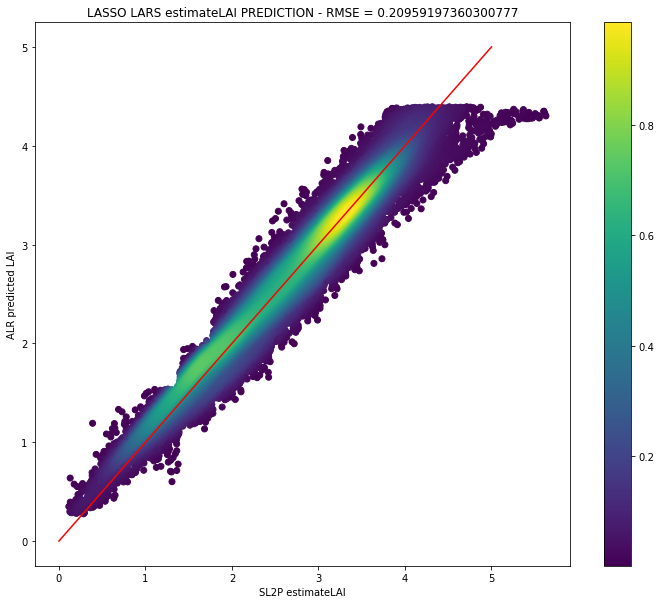

In [48]:
a_tf_LAI = np.linspace(0, 5, 5000)
fig, ax = plt.subplots(1, 1, figsize=(12,10))

fig1 = ax.scatter(x_tf_LAI, y_tf_LAI, c=z_tf_LAI)
ax.plot(a_tf_LAI, a_tf_LAI, c='r')
ax.set_xlabel('SL2P estimateLAI')
ax.set_ylabel('ALR predicted LAI')
plt.colorbar(mappable=fig1, ax=ax)

ax.title.set_text('LASSO LARS {} PREDICTION - RMSE = {}'.format('estimateLAI', rmse_tf_LAI))

Early attempts to use the output of the kerasModel.get_weights() to apply the neural network weights manually

In [37]:
LAI_model.get_weights()

[array([[-0.19410925,  0.36695847, -0.48405492,  0.00166902, -0.4979479 ],
        [ 0.13523632, -0.00448164,  0.78042036, -0.18590523, -0.23591124],
        [ 0.42825207,  0.09607866,  0.15772615, -0.12263177,  0.48040524],
        [-0.27082226, -0.7377516 ,  0.2056712 ,  0.70486426,  0.2169241 ],
        [-0.15604219, -0.21770196,  0.08762774,  0.24267223, -0.62314177]],
       dtype=float32),
 array([-0.5783012 ,  0.39667457,  0.07547248,  0.3044833 ,  0.6540118 ],
       dtype=float32),
 array([[ 0.581533  , -0.50976276,  0.12827909,  0.05663702],
        [-0.6726477 ,  0.44787493,  0.9011054 ,  0.80054265],
        [-0.54570836, -0.25182045,  0.38470638, -0.1506631 ],
        [-0.6138239 , -0.15914883, -0.6856905 ,  0.31080022],
        [-0.00387099,  1.5446616 , -0.54435253, -0.38439253]],
       dtype=float32),
 array([-0.44638988,  0.75462484,  0.12912919,  0.07634029], dtype=float32),
 array([[ 0.88198286, -0.18201818,  0.50380474],
        [ 1.0907607 ,  0.5567267 ,  0.140037

In [38]:
elu = np.vectorize(alr.elu)
softplus = np.vectorize(alr.softplus)
softsign = np.vectorize(alr.softsign)
relu = np.vectorize(alr.relu)
tanh = np.vectorize(alr.tanh)
sigmoid = np.vectorize(alr.sigmoid)

In [39]:
row = 4802
inputs = X.iloc[row, :].to_numpy()
print(LAI_model.predict(inputs.reshape((-1,5)))[0][0])
print(alr.apply_nnet(inputs, LAI_model)[0])

1.4363577
1.4363580427456382


In [40]:
# Writing the neural network to a CSV file to be uploaded to the server side on Google Earth Engine
export_data = alr.export_nnet(LAI_model, X)
with open('nnet.csv', 'w', newline='') as csvfile:
    nnet_writer = csv.writer(csvfile)
    for layerdata in export_data:
        nnet_writer.writerow(layerdata)